<a href="https://colab.research.google.com/github/sreesriavvaru123/MI/blob/main/PTB_XL_2_classes_v2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab-compatible notebook for MI and CDs detection using PTB-XL with 1-leads and 5-fold CV




## STEP 1: Install necessary packages



In [1]:
# Multi-branch Fusion Network for Myocardial Infarction Detection on PTB-XL
# Google Colab Version - Adapted from the original paper
# Binary Classification: MI vs Non-MI

# Install required packages
!pip install wfdb requests tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 97.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


## STEP 2: Read database

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import wfdb
import os
import ast
import requests
import zipfile
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## STEP 3: Load metadata and diagnostic class mapping

In [3]:
def load_ptbxl_metadata(path):
    data = pd.read_csv(os.path.join(path, 'ptbxl_database.csv'))
    data.scp_codes = data.scp_codes.apply(lambda x: ast.literal_eval(x))
    return data

# Load SCP statements
def load_diagnostic_class_mapping(path):
    return pd.read_csv(os.path.join(path, 'scp_statements.csv'), index_col=0)

## STEP 4: Apply MI vs Non-MI filter

In [4]:
def apply_diagnostic_filter_5class(data, class_map):
    # Step 1: Map SCP codes to diagnostic classes
    data['diagnostic_class'] = data.scp_codes.apply(
        lambda x: list(set([class_map.loc[k].diagnostic_class for k in x if k in class_map.index]))
    )

    # Step 2: Assign a single label per record based on priority
    priority_list = ['MI', 'STTC', 'CD', 'HYP', 'NORM']
    def assign_label(class_list):
        for cls in priority_list:
            if cls in class_list:
                return cls
        return 'Other'

    data['diagnostic_label'] = data.diagnostic_class.apply(assign_label)

    return data



## STEP 5: Load ECG signals

In [5]:
def load_raw_data(df, sampling_rate, path):
    data = []
    for i in range(len(df)):
        record_name = df.iloc[i].filename_lr if sampling_rate == 100 else df.iloc[i].filename_hr
        record_path = os.path.join(path, record_name)
        signal, _ = wfdb.rdsamp(record_path)
        data.append(signal)
    return np.array(data)

In [7]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"avvarusrinivasulu","key":"fe47c5051ef67f1130ff6e2e1fa439be"}'}

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle CLI if not already
!pip install -q kaggle

# Download the PTB-XL dataset
!kaggle datasets download -d khyeh0719/ptb-xl-dataset

# Unzip the dataset
!unzip ptb-xl-dataset.zip -d ptb-xl


Streaming output truncated to the last 5000 lines.
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/1934

## STEP 7: Main pipeline

In [33]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class PTBXLDataLoader:
    """Data loader for PTB-XL database - Google Colab version"""

    def __init__(self, data_path='/content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'):
        self.data_path = data_path
        self.sampling_rate = 100
        self.lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    # def download_ptbxl(self):
    #     """Download PTB-XL database automatically"""
    #     if not os.path.exists(self.data_path):
    #         print("Downloading PTB-XL database...")
    #         os.makedirs(self.data_path, exist_ok=True)

    #         # Download metadata
    #         print("Downloading metadata...")
    #         metadata_url = "https://physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv"
    #         response = requests.get(metadata_url)
    #         with open(os.path.join(self.data_path, 'ptbxl_database.csv'), 'wb') as f:
    #             f.write(response.content)

    #         # Download statements
    #         statements_url = "https://physionet.org/files/ptb-xl/1.0.3/scp_statements.csv"
    #         response = requests.get(statements_url)
    #         with open(os.path.join(self.data_path, 'scp_statements.csv'), 'wb') as f:
    #             f.write(response.content)

    #         # Download the actual records
    #         print("Downloading PTB-XL records (this may take 5-10 minutes)...")
    #         records_url = "https://physionet.org/files/ptb-xl/1.0.3/records100.zip"

    #         response = requests.get(records_url, stream=True)
    #         total_size = int(response.headers.get('content-length', 0))

    #         zip_path = os.path.join(self.data_path, 'records100.zip')
    #         with open(zip_path, 'wb') as f, tqdm(
    #             desc="Downloading",
    #             total=total_size,
    #             unit='B',
    #             unit_scale=True,
    #             unit_divisor=1024,
    #         ) as pbar:
    #             for chunk in response.iter_content(chunk_size=8192):
    #                 if chunk:
    #                     f.write(chunk)
    #                     pbar.update(len(chunk))

    #         # Extract the zip file
    #         print("Extracting records...")
    #         with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    #             zip_ref.extractall(self.data_path)

        #     # Clean up
        #     os.remove(zip_path)
        #     print("PTB-XL database downloaded successfully!")
        # else:
        #     print("PTB-XL database already exists.")

    def load_metadata(self):
        """Load PTB-XL metadata and create MI labels"""
        try:
            # Load database info
            df = pd.read_csv(os.path.join(self.data_path, 'ptbxl_database.csv'))

            # Parse SCP codes safely
            def parse_scp_codes(scp_string):
                try:
                    return ast.literal_eval(scp_string) if pd.notna(scp_string) else {}
                except:
                    return {}

            df['scp_codes_parsed'] = df.scp_codes.apply(parse_scp_codes)

            # Define MI-related codes
            mi_codes = ['STEMI', 'NSTEMI', 'IMI', 'AMI', 'ALMI', 'ILMI', 'PLMI', 'ASMI', 'IWMI']

            # Create binary MI labels
            def has_mi(scp_dict):
                if not isinstance(scp_dict, dict):
                    return False
                return any(code in scp_dict for code in mi_codes)

            df['is_mi'] = df['scp_codes_parsed'].apply(has_mi)

            # # Filter for 100Hz sampling rate
            # df = df[df.sampling_rate == 100].copy()

            print(f"Dataset Statistics:")
            print(f"  Total records (100Hz): {len(df)}")
            print(f"  MI cases: {df['is_mi'].sum()}")
            print(f"  Non-MI cases: {(~df['is_mi']).sum()}")
            print(f"  MI prevalence: {df['is_mi'].mean()*100:.1f}%")

            return df

        except FileNotFoundError as e:
            print(f"Error loading metadata: {e}")
            return None

    def load_signal(self, filename_lr):
        """Load a single ECG signal from PTB-XL"""
        try:
            record_path = os.path.join(self.data_path, filename_lr)
            record_path = record_path.replace('.dat', '')

            record = wfdb.rdrecord(record_path)
            signal = record.p_signal[:, :12]  # 12-lead ECG

            return signal

        except Exception as e:
            return None


    def prepare_dataset(self, max_samples_per_class=1000, min_length=1000):
        """Prepare balanced dataset for MI vs Non-MI classification"""
        df = self.load_metadata()
        if df is None:
            return None, None, None

        # Separate MI and Non-MI cases
        mi_df = df[df['is_mi'] == True].copy()
        non_mi_df = df[df['is_mi'] == False].copy()

        print(f"Before balancing:")
        print(f"  MI samples: {len(mi_df)}")
        print(f"  Non-MI samples: {len(non_mi_df)}")

        # Balance dataset
        if max_samples_per_class:
            mi_df = mi_df.sample(min(max_samples_per_class, len(mi_df)), random_state=42)
            non_mi_df = non_mi_df.sample(min(max_samples_per_class, len(non_mi_df)), random_state=42)
        else:
            # Balance to smaller class
            min_samples = min(len(mi_df), len(non_mi_df))
            mi_df = mi_df.sample(min_samples, random_state=42)
            non_mi_df = non_mi_df.sample(min_samples, random_state=42)

        # Combine balanced dataset
        balanced_df = pd.concat([mi_df, non_mi_df]).sample(frac=1, random_state=42).reset_index(drop=True)

        print(f"After balancing:")
        print(f"  MI samples: {len(mi_df)}")
        print(f"  Non-MI samples: {len(non_mi_df)}")
        print(f"  Total samples: {len(balanced_df)}")

        # Load signals
        signals = []
        labels = []
        failed_loads = 0

        print("Loading ECG signals...")
        for idx, row in tqdm(balanced_df.iterrows(), total=len(balanced_df)):
            signal = self.load_signal(row.filename_lr)

            if signal is not None and signal.shape[0] >= min_length:
                signals.append(signal)
                labels.append(int(row.is_mi))
            else:
                failed_loads += 1

        if failed_loads > 0:
            print(f"Failed to load {failed_loads} signals")

        print(f"Successfully loaded {len(signals)} signals")

        return np.array(signals), np.array(labels), balanced_df

In [46]:
class MultiBranchFusionNetwork:
    """Multi-branch fusion network adapted for time-series ECG data"""

    def __init__(self, input_length=1000, num_leads=12):
        self.input_length = input_length
        self.num_leads = num_leads
        self.model = None
        self.lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    def create_shallow_branch(self, input_shape, lead_name):
        """Create shallow neural network branch (as per paper)"""
        inputs = keras.Input(shape=input_shape, name=f'{lead_name}_input')

        # First conv layer (3x3 -> 1D kernel size 3)
        x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', name=f'{lead_name}_conv1')(inputs)
        x = layers.MaxPooling1D(pool_size=2, name=f'{lead_name}_pool1')(x)

        # Second conv layer
        x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', name=f'{lead_name}_conv2')(x)
        x = layers.MaxPooling1D(pool_size=2, name=f'{lead_name}_pool2')(x)

        # Output 32 features per branch (as per paper)
        x = layers.GlobalAveragePooling1D(name=f'{lead_name}_global_avg_pool')(x)
        x = layers.Dense(32, activation='relu', name=f'{lead_name}_dense')(x)

        return keras.Model(inputs, x, name=f'{lead_name}_shallow_branch')

    def create_densenet_classifier(self, input_dim):
        """Create DenseNet-based classification network"""
        inputs = keras.Input(shape=(input_dim,), name='classifier_input')

        # Dense blocks with growth rate 24 (as per paper)
        x = layers.Dense(192, activation='relu', name='classifier_dense1')(inputs)
        x = layers.Dropout(0.2, name='classifier_dropout1')(x)

        x = layers.Dense(288, activation='relu', name='classifier_dense2')(x)
        x = layers.Dropout(0.2, name='classifier_dropout2')(x)

        x = layers.Dense(144, activation='relu', name='classifier_dense3')(x)
        x = layers.Dropout(0.2, name='classifier_dropout3')(x)

        x = layers.Dense(72, activation='relu', name='classifier_dense4')(x)
        x = layers.Dropout(0.2, name='classifier_dropout4')(x)

        # Binary classification output
        outputs = layers.Dense(1, activation='sigmoid', name='mi_prediction')(x)

        return keras.Model(inputs, outputs, name='densenet_classifier')

    def build_model(self):
        """Build the complete multi-branch fusion network"""

        # Create 12 input branches (one for each lead)
        lead_inputs = []
        branch_outputs = []

        for i in range(self.num_leads):
            # Input for lead i
            lead_input = keras.Input(shape=(self.input_length,), name=f'lead_{self.lead_names[i]}_input')
            lead_inputs.append(lead_input)

            # Reshape for conv1d processing
            reshaped = layers.Reshape((self.input_length, 1), name=f'lead_{self.lead_names[i]}_reshape')(lead_input)

            # Create shallow branch for this lead with unique name
            branch = self.create_shallow_branch((self.input_length, 1), self.lead_names[i])
            branch_output = branch(reshaped)
            branch_outputs.append(branch_output)

        # Feature fusion - depth concatenation (as per paper)
        # 12 leads × 32 features = 384 features total
        fused_features = layers.Concatenate(axis=-1, name='feature_fusion')(branch_outputs)

        # Classification network
        classifier = self.create_densenet_classifier(fused_features.shape[-1])
        final_output = classifier(fused_features)

        # Create complete model
        self.model = keras.Model(
            inputs=lead_inputs,
            outputs=final_output,
            name='MultiBranchFusionNetwork_MI_Detection'
        )

        return self.model

    def compile_model(self, learning_rate=0.05):
        """Compile model with SGD optimizer (as per paper)"""
        optimizer = keras.optimizers.SGD(
            learning_rate=learning_rate,
            momentum=0.9,
            decay=1e-6
        )

        self.model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=16):
        """Train the model"""

        # Prepare inputs for multi-branch network
        X_train_list = [X_train[:, :, i] for i in range(self.num_leads)]
        X_val_list = [X_val[:, :, i] for i in range(self.num_leads)]

        # Callbacks
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )

        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )

        # Train model
        print(f"Starting training...")
        print(f"  Training samples: {len(X_train)}")
        print(f"  Validation samples: {len(X_val)}")
        print(f"  Batch size: {batch_size}")
        print(f"  Max epochs: {epochs}")

        history = self.model.fit(
            X_train_list, y_train,
            validation_data=(X_val_list, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        return history

    def predict(self, X_test):
        """Make predictions"""
        X_test_list = [X_test[:, :, i] for i in range(self.num_leads)]
        return self.model.predict(X_test_list)

    def evaluate(self, X_test, y_test, threshold=0.5):
        """Comprehensive evaluation (as per paper metrics)"""

        # Get predictions
        y_pred_proba = self.predict(X_test)
        y_pred = (y_pred_proba > threshold).astype(int).flatten()

        # Calculate metrics (as per paper)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        metrics = {
            'accuracy': (tp + tn) / (tp + fp + fn + tn),
            'sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
            'f1_score': f1_score(y_test, y_pred)
        }

        return metrics, y_pred, y_pred_proba

In [35]:
def preprocess_signals(signals, target_length=1000):
    """Preprocess ECG signals to fixed length"""
    processed_signals = []

    print(f"Preprocessing signals to length {target_length}...")

    for signal in tqdm(signals):
        if signal.shape[0] > target_length:
            # Take middle portion (most stable part)
            start_idx = (signal.shape[0] - target_length) // 2
            signal = signal[start_idx:start_idx + target_length]
        elif signal.shape[0] < target_length:
            # Pad with last value
            padding = target_length - signal.shape[0]
            last_values = signal[-1:].repeat(padding, axis=0)
            signal = np.vstack([signal, last_values])

        processed_signals.append(signal)

    return np.array(processed_signals)

In [36]:
def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [37]:
def plot_sample_ecg(signals, labels, idx=0):
    """Plot sample 12-lead ECG"""
    fig, axes = plt.subplots(4, 3, figsize=(18, 12))
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    # Time axis (assuming 100Hz sampling)
    time_axis = np.arange(signals[idx].shape[0]) / 100  # Convert to seconds

    for i, ax in enumerate(axes.flat):
        if i < 12:
            ax.plot(time_axis, signals[idx, :, i], linewidth=1.5, color='blue')
            ax.set_title(f'Lead {lead_names[i]}', fontsize=12)
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Amplitude (mV)')
            ax.grid(True, alpha=0.3)

    label_text = "MI (Myocardial Infarction)" if labels[idx] else "Non-MI (Normal)"
    fig.suptitle(f'12-Lead ECG - {label_text}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [38]:
def print_results_table(metrics):
    """Print results in paper format"""
    print("\n" + "="*60)
    print("PERFORMANCE RESULTS (Paper Format)")
    print("="*60)
    print(f"{'Metric':<20} {'Value':<15} {'Percentage':<15}")
    print("-" * 60)
    print(f"{'Accuracy':<20} {metrics['accuracy']:<15.4f} {metrics['accuracy']*100:<15.2f}%")
    print(f"{'Sensitivity':<20} {metrics['sensitivity']:<15.4f} {metrics['sensitivity']*100:<15.2f}%")
    print(f"{'Specificity':<20} {metrics['specificity']:<15.4f} {metrics['specificity']*100:<15.2f}%")
    print(f"{'F1-score':<20} {metrics['f1_score']:<15.4f} {metrics['f1_score']*100:<15.2f}%")
    print("="*60)


In [42]:
def main():
    """Main execution pipeline"""

    print("="*80)
    print("MULTI-BRANCH FUSION NETWORK FOR MI DETECTION - GOOGLE COLAB")
    print("Paper: Multi-branch fusion network for Myocardial infarction screening")
    print("Database: PTB-XL (PhysioNet)")
    print("Task: Binary Classification (MI vs Non-MI)")
    print("="*80)

    # Step 1: Download and load data
    print("\nSTEP 1: Loading PTB-XL Database...")
    data_loader = PTBXLDataLoader()

    # Download dataset
    # data_loader.download_ptbxl()

    # Load dataset
    signals, labels, df = data_loader.prepare_dataset(max_samples_per_class=1000)

    if signals is None or len(signals) == 0:
        print("No signals loaded. Please check dataset integrity.")
        return None, None, None

    print(f"\nDataset loaded successfully!")
    print(f"  Signal shape: {signals[0].shape} (time_steps, leads)")
    print(f"  Total samples: {len(signals)}")
    print(f"  MI cases: {np.sum(labels)} ({np.mean(labels)*100:.1f}%)")

    # Step 2: Preprocess signals
    print(f"\nSTEP 2: Preprocessing Signals...")
    signals = preprocess_signals(signals, target_length=1000)

    # Normalize signals
    print("Normalizing signals...")
    signals_normalized = np.zeros_like(signals)
    for lead_idx in range(signals.shape[2]):
        lead_data = signals[:, :, lead_idx]
        scaler = StandardScaler()
        signals_normalized[:, :, lead_idx] = scaler.fit_transform(lead_data)

    signals = signals_normalized
    print(f"Preprocessed signal shape: {signals.shape}")

    # Plot sample ECG
    plot_sample_ecg(signals, labels, idx=0)

    # Step 3: Split dataset
    print(f"\nSTEP 3: Splitting Dataset...")
    X_train, X_temp, y_train, y_temp = train_test_split(
        signals, labels, test_size=0.4, random_state=42, stratify=labels
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"  Training: {X_train.shape[0]} samples ({np.sum(y_train)} MI)")
    print(f"  Validation: {X_val.shape[0]} samples ({np.sum(y_val)} MI)")
    print(f"  Test: {X_test.shape[0]} samples ({np.sum(y_test)} MI)")

    # Step 4: Build and train model
    print(f"\nSTEP 4: Building Multi-Branch Fusion Network...")

    model_builder = MultiBranchFusionNetwork(
        input_length=signals.shape[1],
        num_leads=signals.shape[2]
    )

    # Build model
    model = model_builder.build_model()
    model_builder.compile_model(learning_rate=0.05)

    print(f"\nModel Architecture:")
    model.summary()

    # Train model
    print(f"\nSTEP 5: Training Model...")
    history = model_builder.train(
        X_train, y_train,
        X_val, y_val,
        epochs=50,
        batch_size=16
    )

    # Plot training history
    plot_training_history(history)

    # Step 6: Evaluate model
    print(f"\nSTEP 6: Evaluating Model...")
    metrics, y_pred, y_pred_proba = model_builder.evaluate(X_test, y_test)

    # Print results
    print_results_table(metrics)

    # Compare with paper results
    paper_results = {
        'accuracy': 0.9473,
        'sensitivity': 0.9641,
        'specificity': 0.9594,
        'f1_score': 0.9379
    }

    print(f"\nCOMPARISON WITH PAPER RESULTS:")
    print("-" * 60)
    for metric in ['accuracy', 'sensitivity', 'specificity', 'f1_score']:
        diff = metrics[metric] - paper_results[metric]
        print(f"{metric.capitalize():<20} Ours: {metrics[metric]*100:6.2f}%  Paper: {paper_results[metric]*100:6.2f}%  Diff: {diff*100:+5.2f}%")

    # Step 7: Save model to Google Drive
    print(f"\nSTEP 7: Saving Model to Google Drive...")
    model.save('/content/drive/MyDrive/mi_detection_model.h5')

    # Save results
    results_df = pd.DataFrame([metrics])
    results_df.to_csv('/content/drive/MyDrive/mi_detection_results.csv', index=False)

    print("Model and results saved to Google Drive!")

    return model, metrics, history

MULTI-BRANCH FUSION NETWORK FOR MI DETECTION - GOOGLE COLAB
Paper: Multi-branch fusion network for Myocardial infarction screening
Database: PTB-XL (PhysioNet)
Task: Binary Classification (MI vs Non-MI)

STEP 1: Loading PTB-XL Database...
Dataset Statistics:
  Total records (100Hz): 21837
  MI cases: 5108
  Non-MI cases: 16729
  MI prevalence: 23.4%
Before balancing:
  MI samples: 5108
  Non-MI samples: 16729
After balancing:
  MI samples: 1000
  Non-MI samples: 1000
  Total samples: 2000
Loading ECG signals...


100%|██████████| 2000/2000 [00:04<00:00, 426.02it/s]


Successfully loaded 2000 signals

Dataset loaded successfully!
  Signal shape: (1000, 12) (time_steps, leads)
  Total samples: 2000
  MI cases: 1000 (50.0%)

STEP 2: Preprocessing Signals...
Preprocessing signals to length 1000...


100%|██████████| 2000/2000 [00:00<00:00, 898234.07it/s]


Normalizing signals...
Preprocessed signal shape: (2000, 1000, 12)


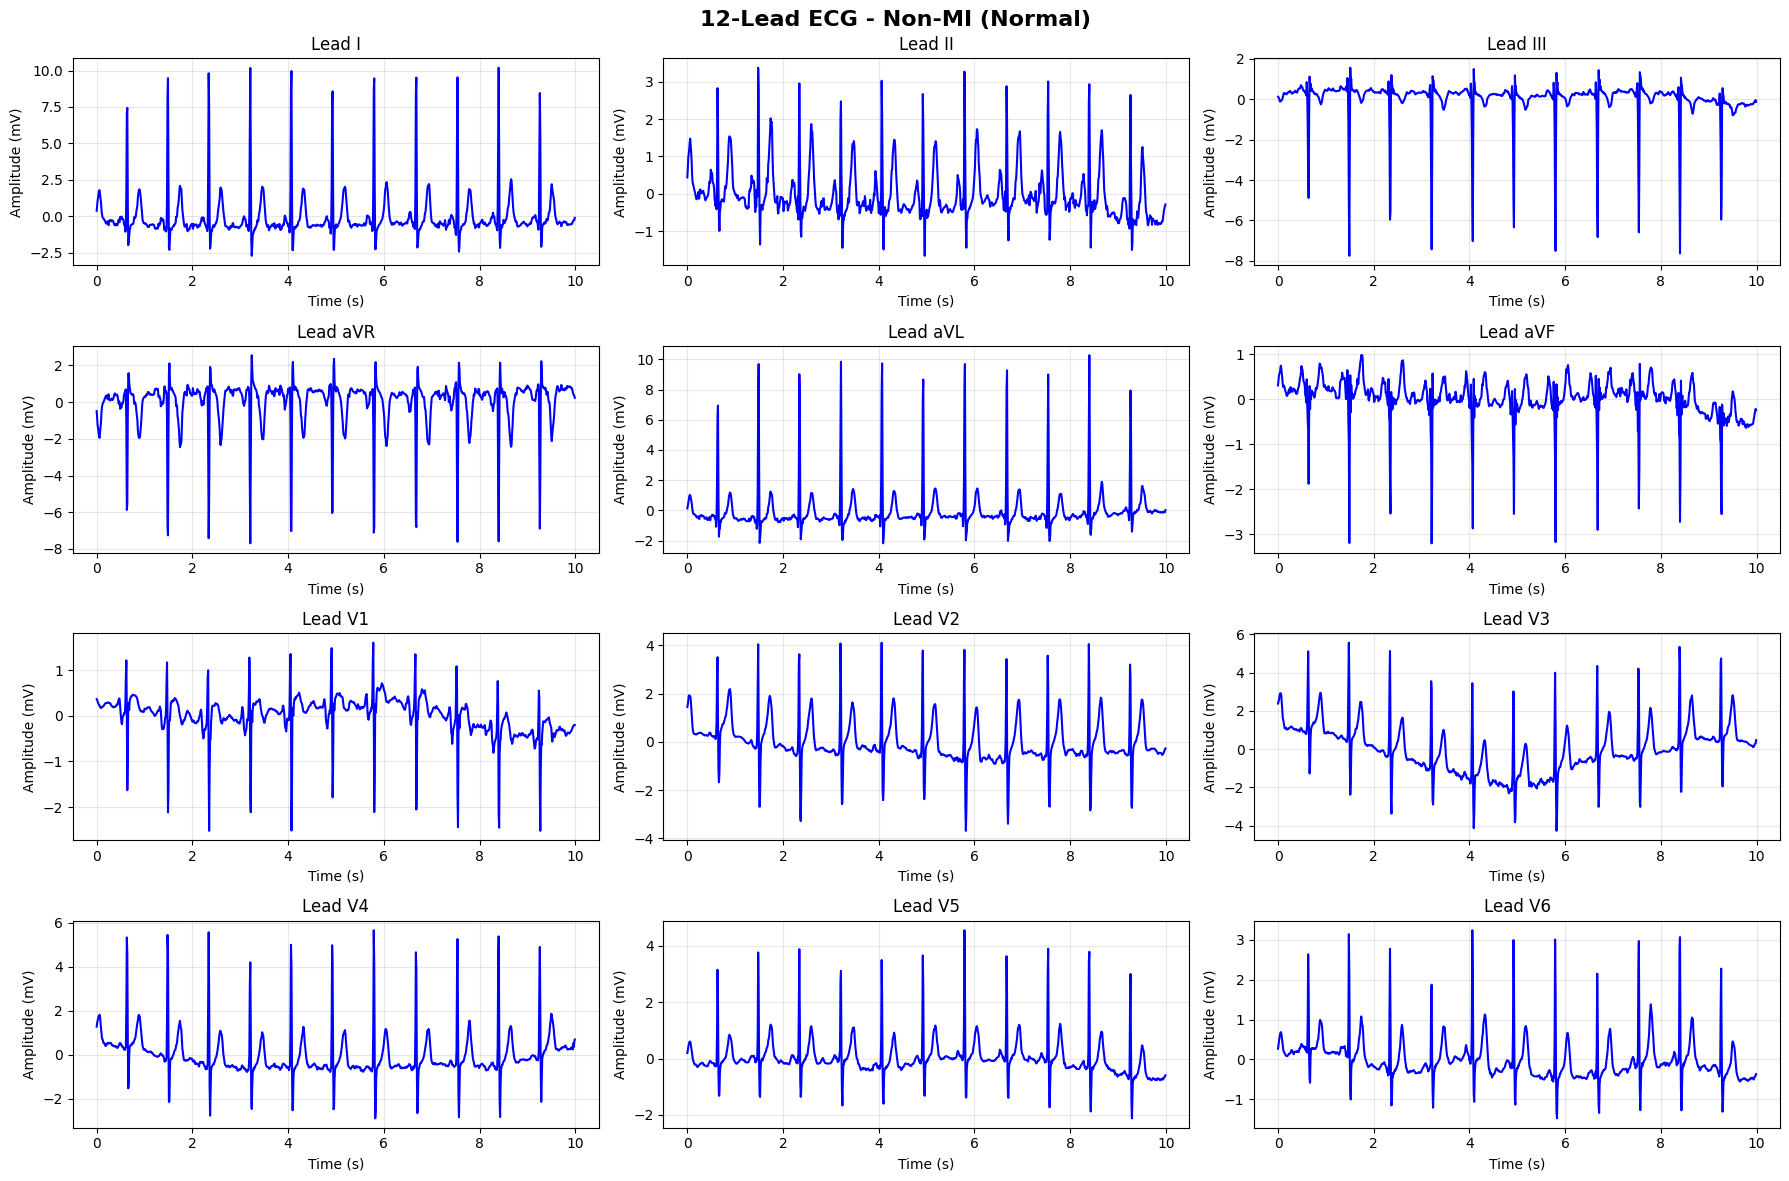


STEP 3: Splitting Dataset...
  Training: 1200 samples (600 MI)
  Validation: 400 samples (200 MI)
  Test: 400 samples (200 MI)

STEP 4: Building Multi-Branch Fusion Network...

Model Architecture:


Model: "MultiBranchFusionNetwork_MI_Detection"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lead_I_input        │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_II_input       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_III_input      │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_aVR_input      │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_aVL_input      │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_aVF_input      │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_V1_input       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_V2_input       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_V3_input       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_V4_input       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_V5_input       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_V6_input       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_I_reshape      │ (None, 1000, 1)   │          0 │ lead_I_input[0][… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_II_reshape     │ (None, 1000, 1)   │          0 │ lead_II_input[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_III_reshape    │ (None, 1000, 1)   │          0 │ lead_III_input[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_aVR_reshape    │ (None, 1000, 1)   │          0 │ lead_aVR_input[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_aVL_reshape    │ (None, 1000, 1)   │          0 │ lead_aVL_input[0

 Total params: 233,089 (910.50 KB)

 Trainable params: 233,089 (910.50 KB)

 Non-trainable params: 0 (0.00 B)


STEP 5: Training Model...
Starting training...
  Training samples: 1200
  Validation samples: 400
  Batch size: 16
  Max epochs: 50
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.4914 - loss: 0.6980 - val_accuracy: 0.5000 - val_loss: 0.6911 - learning_rate: 0.0500
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.5094 - loss: 0.6962 - val_accuracy: 0.5050 - val_loss: 0.6894 - learning_rate: 0.0500
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5555 - loss: 0.6771 - val_accuracy: 0.6250 - val_loss: 0.6521 - learning_rate: 0.0500
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6831 - loss: 0.6283 - val_accuracy: 0.5000 - val_loss: 0.6787 - learning_rate: 0.0500
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6114 - loss: 0.6429 - val_accuracy: 0.6200 - val_loss: 0.6275 - learning_rate: 0.0500
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7049 - loss: 0.5845 - val_accuracy: 0.6400 - 

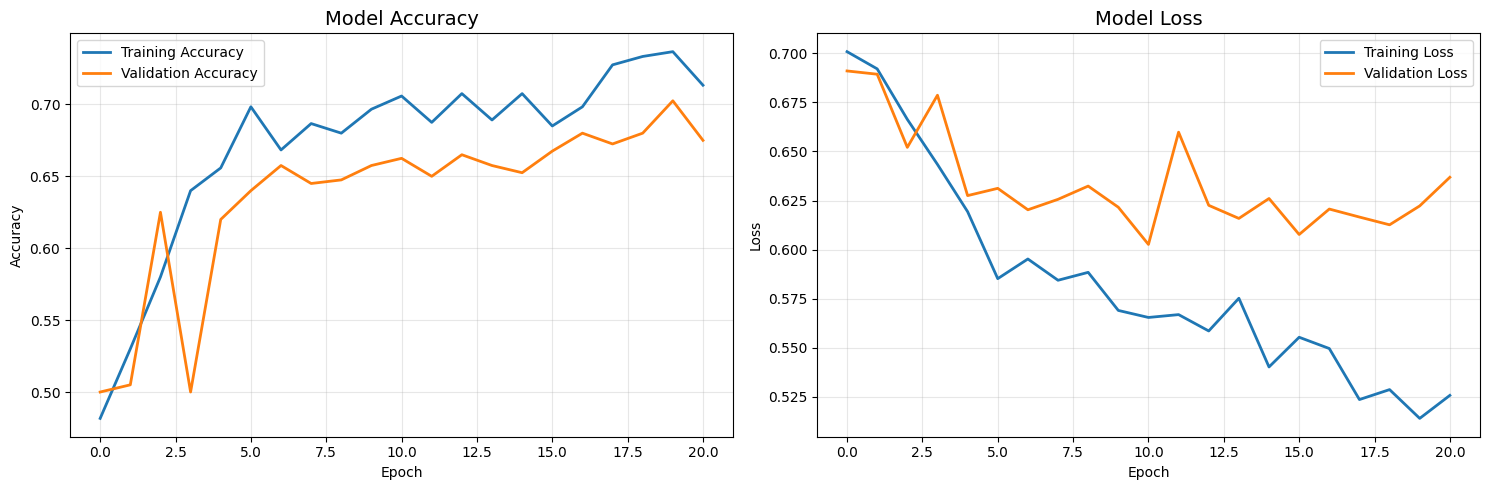


STEP 6: Evaluating Model...
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step



PERFORMANCE RESULTS (Paper Format)
Metric               Value           Percentage     
------------------------------------------------------------
Accuracy             0.7450          74.50          %
Sensitivity          0.8050          80.50          %
Specificity          0.6850          68.50          %
F1-score             0.7594          75.94          %

COMPARISON WITH PAPER RESULTS:
------------------------------------------------------------
Accuracy             Ours:  74.50%  Paper:  94.73%  Diff: -20.23%
Sensitivity          Ours:  80.50%  Paper:  96.41%  Diff: -15.91%
Specificity          Ours:  68.50%  Paper:  95.94%  Diff: -27.44%
F1_score             Ours:  75.94%  Paper:  93.79%  Diff: -17.85%

STEP 7: Saving Model to Google Drive...
Model and results saved to Google Drive!


In [47]:
# Run the main pipeline
if __name__ == "__main__":
    model, metrics, history = main()

## STEP 6: Define ResNet-like model

## Model setup and Training

## Testing the Model